# Description

<img src="http://www.vision.caltech.edu/visipedia/collage.jpg"/>

# Datasets

## 1) Caltech-UCSD Birds-200-2011

### description

Caltech-UCSD Birds-200-2011 (CUB-200-2011) is an extended version of the CUB-200 dataset, with roughly double the number of images per class and new part location annotations. For detailed information about the dataset, please see the technical report linked below.

Number of categories: 200

Number of images: 11,788

Annotations per image: 15 Part Locations, 312 Binary Attributes, 1 Bounding Box

Some related datasets are Caltech-256, the Oxford Flower Dataset, and Animals with Attributes. More datasets are available at the Caltech Vision Dataset Archive.

### Source

```
@techreport{WahCUB_200_2011,
	Title = {{The Caltech-UCSD Birds-200-2011 Dataset}},
	Author = {Wah, C. and Branson, S. and Welinder, P. and Perona, P. and Belongie, S.},
	Year = {2011}
	Institution = {California Institute of Technology},
	Number = {CNS-TR-2011-001}
}
```

http://www.vision.caltech.edu/visipedia-data/CUB-200-2011/CUB_200_2011.tgz

## 2) NABirds

## Description 

NABirds V1 is a collection of 48,000 annotated photographs of the 400 species of birds that are commonly observed in North America. More than 100 photographs are available for each species, including separate annotations for males, females and juveniles that comprise 700 visual categories. This dataset is to be used for fine-grained visual categorization experiments.

More than 550 visual categories, organized taxonomically
Photos curated in collaboration with domain experts

## Source

```
Grant Van Horn (gvanhorn@caltech.edu) 
http://dl.allaboutbirds.org/nabirds
```

# Download

**CUB_200_2011**

In [ ]:
!wget http://www.vision.caltech.edu/visipedia-data/CUB-200-2011/CUB_200_2011.tgz

** NABirds**

Need to use cookies to download from dropbox

In [ ]:
!wget -x --load-cookies cookies.txt "https://www.dropbox.com/s/nf78cbxq6bxpcfc/nabirds.tar.gz?oref=e&n=13142758&submissionGuid=52cdf879-69ff-4c86-9b33-c3118b032f8b"

In [ ]:
!mv "www.dropbox.com/s/nf78cbxq6bxpcfc/nabirds.tar.gz?oref=e&n=13142758&submissionGuid=52cdf879-69ff-4c86-9b33-c3118b032f8b" nabirds.tar.gz

In [1]:
DATA_DIR = "../data/"

In [ ]:
!tar -xf {DATA_DIR}/nabirds.tar.gz 

In [ ]:
!ls {DATA_DIR}/nabirds.tar.gz

In [ ]:
!ls {DATA_DIR}/nabirds/parts/

In [ ]:
!ls {DATA_DIR}/nabirds/images/


In [ ]:
!pip install scikit-image

In [ ]:
!pip install joblib

In [2]:
import matplotlib.pyplot as plt
from skimage import io as skio
import pandas as pd
import csv
from tqdm import tqdm
import shutil
import os
import os
import tqdm
from joblib import Parallel, delayed

%matplotlib inline

In [ ]:
!ls  {DATA_DIR}/nabirds/

# Preprocess Images

- extract image based on bounding boxes
- flatten/reduce bird hierachy  ( species A male/female  vs species A)

In [3]:
def load_image_paths(dataset_path='', path_prefix=''):
  
  paths = {}
  
  with open(os.path.join(dataset_path, 'images.txt')) as f:
    for line in f:
      pieces = line.strip().split()
      image_id = pieces[0]
      path = os.path.join(path_prefix, pieces[1])
      paths[image_id] = path
  
  return paths

In [4]:
def load_bounding_box_annotations(dataset_path=''):
  
  bboxes = {}
  
  with open(os.path.join(dataset_path, 'bounding_boxes.txt')) as f:
    for line in f:
        pieces = line.strip().split()
        image_id = pieces[0]
        bbox = list(map(int, pieces[1:]))
        bboxes[image_id] = bbox
  
  return bboxes

In [5]:
def load_hierarchy(dataset_path=''):
  
  parents = {}
  
  with open(os.path.join(dataset_path, 'hierarchy.txt')) as f:
    for line in f:
      pieces = line.strip().split()
      child_id, parent_id = pieces
      parents[child_id] = parent_id
  
  return parents

In [6]:
def load_class_names(dataset_path=''):
  
  names = {}
  
  with open(os.path.join(dataset_path, 'classes.txt')) as f:
    for line in f:
      pieces = line.strip().split()
      class_id = pieces[0]
      names[class_id] = ' '.join(pieces[1:])
  
  return names


In [7]:
def load_image_labels(dataset_path=''):
  labels = {}
  
  with open(os.path.join(dataset_path, 'image_class_labels.txt')) as f:
    for line in f:
      pieces = line.strip().split()
      image_id = pieces[0]
      class_id = pieces[1]
      labels[image_id] = class_id
  
  return labels

In [8]:
NA_BIRD_DATA_DIR=f"{DATA_DIR}/nabirds"

In [9]:
image_mapping = load_image_paths(dataset_path=NA_BIRD_DATA_DIR)

In [10]:
bboxes = load_bounding_box_annotations(dataset_path=NA_BIRD_DATA_DIR)
class_hierarchy = load_hierarchy(dataset_path=NA_BIRD_DATA_DIR)

In [11]:
class_names = load_class_names(dataset_path=NA_BIRD_DATA_DIR)

image_class_labels = load_image_labels(dataset_path=NA_BIRD_DATA_DIR)

In [12]:
def flatten_hierachy(visualize=False,  end=None):
    final_class_mappings = []
    for image_id in list(image_mapping.keys())[0:end]:
        label_path = []
        class_label = image_class_labels[image_id]
        class_name = class_names[class_label]
        current_class_label = class_label

        while current_class_label in class_hierarchy:
            label_path.append((class_names[current_class_label], current_class_label))
            current_class_label = class_hierarchy[current_class_label]
            label_path.append((class_names[current_class_label], current_class_label)) # add the root node
        label_path.reverse()

        if visualize:
            print (class_name)
            for depth, (class_name, class_id) in enumerate(label_path):
                line = "\t" * (depth + 1)
                print (line + "|- %s \t[ID: %s]" % (class_name, class_id))

        ( new_class_name, new_class_label) =  label_path[-2]
        final_class_mappings.append({'image_id':image_id,'class_name':class_names[class_label]
                                     , 'class_label':class_label, 'new_class_label':new_class_label
                                    , 'new_class_name': new_class_name
                                    })
        
    return final_class_mappings

We see based on the hierachy, that the classification can go pretty deep  (Bird -> Perching Bird -> Thrushes -> American Robin)

In [13]:
flatten_hierachy(visualize=True,end=50)

Oak Titmouse
	|- Birds 	[ID: 0]
		|- Perching Birds 	[ID: 22]
			|- Perching Birds 	[ID: 22]
				|- Chickadees and Titmice 	[ID: 69]
					|- Chickadees and Titmice 	[ID: 69]
						|- Oak Titmouse 	[ID: 587]
							|- Oak Titmouse 	[ID: 587]
								|- Oak Titmouse 	[ID: 817]
Ovenbird
	|- Birds 	[ID: 0]
		|- Perching Birds 	[ID: 22]
			|- Perching Birds 	[ID: 22]
				|- Wood-Warblers 	[ID: 207]
					|- Wood-Warblers 	[ID: 207]
						|- Ovenbird 	[ID: 251]
							|- Ovenbird 	[ID: 251]
								|- Ovenbird 	[ID: 860]
Savannah Sparrow
	|- Birds 	[ID: 0]
		|- Perching Birds 	[ID: 22]
			|- Perching Birds 	[ID: 22]
				|- New World Sparrows and Allies 	[ID: 212]
					|- New World Sparrows and Allies 	[ID: 212]
						|- Savannah Sparrow 	[ID: 583]
							|- Savannah Sparrow 	[ID: 583]
								|- Savannah Sparrow 	[ID: 900]
Eared Grebe (Nonbreeding/juvenile)
	|- Birds 	[ID: 0]
		|- Grebes 	[ID: 4]
			|- Grebes 	[ID: 4]
				|- Eared Grebe 	[ID: 157]
					|- Eared Grebe 	[ID: 157]
						|- Eared

[{'image_id': '0000139e-21dc-4d0c-bfe1-4cae3c85c829',
  'class_name': 'Oak Titmouse',
  'class_label': '817',
  'new_class_label': '587',
  'new_class_name': 'Oak Titmouse'},
 {'image_id': '0000d9fc-4e02-4c06-a0af-a55cfb16b12b',
  'class_name': 'Ovenbird',
  'class_label': '860',
  'new_class_label': '251',
  'new_class_name': 'Ovenbird'},
 {'image_id': '00019306-9d83-4334-b255-a447742edce3',
  'class_name': 'Savannah Sparrow',
  'class_label': '900',
  'new_class_label': '583',
  'new_class_name': 'Savannah Sparrow'},
 {'image_id': '0001afd4-99a1-4a67-b940-d419413e23b3',
  'class_name': 'Eared Grebe (Nonbreeding/juvenile)',
  'class_label': '645',
  'new_class_label': '157',
  'new_class_name': 'Eared Grebe'},
 {'image_id': '000332b8-997c-4540-9647-2f0a8495aecf',
  'class_name': 'Eastern Phoebe',
  'class_label': '929',
  'new_class_label': '420',
  'new_class_name': 'Eastern Phoebe'},
 {'image_id': '000343bd-5215-49ba-ab9c-7c97a70ac1a5',
  'class_name': 'Yellow-crowned Night-Heron (I

In [14]:
final_class_df = pd.DataFrame(flatten_hierachy(visualize=False))

In [15]:
final_class_df.head()

,class_label,class_name,image_id,new_class_label,new_class_name
0,817,Oak Titmouse,0000139e-21dc-4d0c-bfe1-4cae3c85c829,587,Oak Titmouse
1,860,Ovenbird,0000d9fc-4e02-4c06-a0af-a55cfb16b12b,251,Ovenbird
2,900,Savannah Sparrow,00019306-9d83-4334-b255-a447742edce3,583,Savannah Sparrow
3,645,Eared Grebe (Nonbreeding/juvenile),0001afd4-99a1-4a67-b940-d419413e23b3,157,Eared Grebe
4,929,Eastern Phoebe,000332b8-997c-4540-9647-2f0a8495aecf,420,Eastern Phoebe


** Image Masking **

In [16]:
image_id = "000332b8-997c-4540-9647-2f0a8495aecf"
image_mapping[image_id]

'0929/000332b8997c454096472f0a8495aecf.jpg'

In [17]:
bbox_x, bbox_y, bbox_width, bbox_height = bboxes[image_id]
(bbox_x, bbox_y, bbox_width, bbox_height)

(395, 139, 262, 390)

In [18]:
original_img = skio.imread(f'{NA_BIRD_DATA_DIR}/images/{image_mapping[image_id]}')


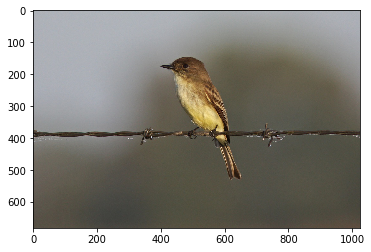

In [19]:
plt.imshow(original_img)

In [20]:
(bbox_x, bbox_y, bbox_width, bbox_height)

(395, 139, 262, 390)

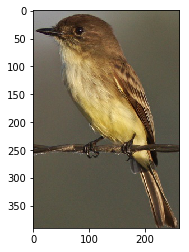

In [21]:
plt.imshow(original_img[bbox_y:bbox_y+bbox_height,bbox_x:bbox_x+bbox_width ])

# Save Final Images

In [22]:
len(final_class_df)

48562

In [23]:
len(image_class_labels)

48562

In [24]:
DATA_DIR

'../data/'

In [25]:
NA_BIRD_DATA_DIR

'../data//nabirds'

In [ ]:
new_dest_path = f"{DATA_DIR}/processed"
shutil.rmtree(new_dest_path, ignore_errors=True)
os.mkdir(new_dest_path)

for record in tqdm.tqdm(final_class_df.to_dict(orient='records')):
    class_label = record['class_label'].zfill(4)
    new_class_label = record['new_class_label'].zfill(4)

    new_class_name = record['new_class_name'].lower().replace(" ","_").replace("'","")
    image_id= record['image_id']
    
    file_name = image_mapping[image_id].replace(class_label+"/","")
    
    current_path = f"{DATA_DIR}/nabirds/images/{class_label}/{file_name}"
    new_path = f"{new_dest_path}/{new_class_name}/{file_name}"
    os.makedirs(f"{new_dest_path}/{new_class_name}",exist_ok=True)
    shutil.copyfile(current_path,new_path)
    
    
    
    bbox_x, bbox_y, bbox_width, bbox_height = bboxes[image_id]

    img = skio.imread(new_path)
    img = img[:,:,:3] # remove transparency
    
    cropped_image = img[bbox_y:bbox_y+bbox_height,bbox_x:bbox_x+bbox_width ]
    
    skio.imsave(new_path,cropped_image,)


  4%|▎         | 1701/48562 [02:22<1:06:28, 11.75it/s]

In [ ]:
? skio.imsave

In [ ]:
new_dest_path = f"{DATA_DIR}/processed"
shutil.rmtree(new_dest_path, ignore_errors=True)
os.mkdir(new_dest_path)

In [ ]:
def process_image(record):
    class_label = record['class_label'].zfill(4)
    new_class_label = record['new_class_label'].zfill(4)

    new_class_name = record['new_class_name'].lower().replace(" ","_").replace("'","")
    image_id= record['image_id']
    
    file_name = image_mapping[image_id].replace(class_label+"/","")
    
    current_path = f"{DATA_DIR}/nabirds/images/{class_label}/{file_name}"
    new_path = f"{new_dest_path}/{new_class_name}/{file_name}"
    os.makedirs(f"{new_dest_path}/{new_class_name}",exist_ok=True)
    shutil.copyfile(current_path,new_path)
    
    
    
    bbox_x, bbox_y, bbox_width, bbox_height = bboxes[image_id]

    img = skio.imread(new_path)
    img = img[:,:,:3] # remove transparency
    
    cropped_image = img[bbox_y:bbox_y+bbox_height,bbox_x:bbox_x+bbox_width ]
    
    skio.imsave(new_path,cropped_image,)


In [ ]:
rows = Parallel(n_jobs=4)(delayed(process_image)(record=record) for record in tqdm.tqdm(final_class_df.to_dict(orient='records')))



In [ ]:
import os

In [ ]:
IMAGE_PATH = os.path.expanduser("~/datasets/bird/nabirds")
DEST_PATH = os.path.expanduser("~/data/bird")

In [ ]:
!ls {IMAGE_PATH}

In [ ]:
!rm -rf {DEST_PATH}

In [ ]:
!cp -r {IMAGE_PATH} {DEST_PATH}

In [ ]:
!ls {DEST_PATH}

# Save to gcs

In [ ]:
!gsutil -q -m cp -r nabirds_processed/* gs://${GCS_BUCKET}/datasets/bird/nabirds/

In [ ]:
print (new_dest_path)